## Librerías

In [1]:
import pandas as pd; import matplotlib.pyplot as plt; import numpy as np; import seaborn as sns

## Lectura y preprocesamiento

In [2]:
df = pd.read_csv('Amazon_Products.csv').drop(columns=['Unnamed: 0'])

In [3]:
#-------------------------Estilos para los gráficos
import matplotlib as mpl
plt.style.use("fivethirtyeight") 
mpl.rcParams["font.size"]=10.5 
mpl.rcParams["legend.fontsize"]=14
mpl.rcParams["font.family"]="serif"
mpl.rcParams["font.weight"]="bold"
mpl.rcParams["legend.fancybox"]=True
mpl.rcParams["xtick.labelsize"]=10
mpl.rcParams["ytick.labelsize"]=16
mpl.rcParams["figure.titleweight"]="bold"
mpl.rcParams["axes.labelweight"]="bold"
mpl.rcParams["figure.facecolor"]="white"
mpl.rcParams["axes.facecolor"]="white"
mpl.rcParams["axes.edgecolor"]="0.2"
mpl.rcParams["axes.linewidth"]=1
mpl.rcParams["axes.titleweight"]="bold"
mpl.rcParams["axes.labelsize"]=16
mpl.rcParams["figure.titlesize"]=20
mpl.rcParams["axes.titlesize"]=25
mpl.rcParams["figure.labelsize"]=16
mpl.rcParams["figure.labelweight"]="bold"
mpl.rcParams['axes.grid']=False

In [4]:
# df.info()

##Conversión de las columnas ratings, numero de ratings, discount_price y actual_price a numérico

def validar_tipo(x):
    try:
        type(float(x)==float)
        return np.float32(x)
    except ValueError:
        return np.nan
    
df['discount_price'] = df['discount_price'].str.replace('₹','')
df['actual_price'] = df['actual_price'].str.replace('₹','')
df['discount_price'] = df['discount_price'].str.replace(',','')
df['actual_price'] = df['actual_price'].str.replace(',','')


df['ratings'] = df['ratings'].apply(validar_tipo)
df['no_of_ratings'] = df['no_of_ratings'].apply(validar_tipo)
df['discount_price'] = df['discount_price'].apply(validar_tipo)
df['actual_price'] = df['actual_price'].apply(validar_tipo)

df['ratings'] = df['ratings'].fillna(df['ratings'].mean())
df['no_of_ratings'] = df['no_of_ratings'].fillna(df['no_of_ratings'].mean())
df['discount_price'] = df['discount_price'].fillna(df['discount_price'].mean())
df['actual_price'] = df['actual_price'].fillna(df['actual_price'].mean())

def optimizar_tipo_dato (serie):
    return serie.astype(np.float32)

df['ratings'] = optimizar_tipo_dato(df['ratings'])
df['no_of_ratings'] = optimizar_tipo_dato(df['no_of_ratings'])
df['discount_price'] = optimizar_tipo_dato(df['discount_price'])
df['actual_price'] = optimizar_tipo_dato(df['actual_price'])

## Análisis exploratorio de datos

In [5]:
##Distribución de los datos numéricos

##Eliminar valores atípicos

def outliers(serie):
    q1 = serie.quantile(0.25)
    q3 = serie.quantile(0.75)
    iqr = q3 -q1
    sup_lim = q3 + 1.5*iqr
    inf_lim = q1 - 1.5*iqr
    serie_clean = serie.loc[(serie>=inf_lim)&(serie<=sup_lim)]
    return serie_clean

df['actual_price'] = outliers(df['actual_price'])
df['discount_price'] = outliers(df['discount_price'])
df['ratings'] = outliers(df['ratings'])
df['no_of_ratings'] = outliers(df['no_of_ratings'])
df['manufacturer'] = df['name'].str.split(' ').str[0]

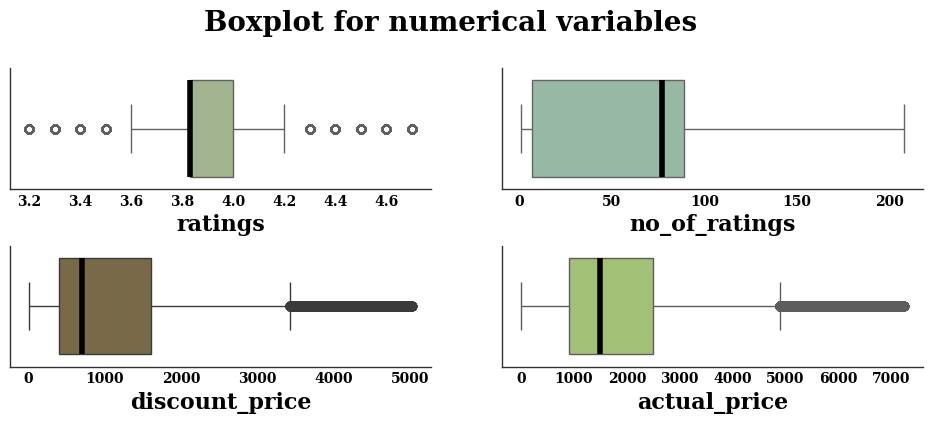

In [6]:
###Boxplot de los datos numéricos

numerical = df.select_dtypes('number')

fig, ax = plt.subplots(ncols=2,nrows=2,figsize=(10,4))
fig.suptitle('Boxplot for numerical variables')
fig.tight_layout(h_pad=2)
colors = ['#A1BA89','#92BDA3','#806D40','#A5CC6B']
ax = ax.flat

for i, col in enumerate(numerical):
    ax[i].spines[['top','right']].set_visible(False)
    sns.boxplot(x=numerical[col],ax=ax[i],color=colors[i],medianprops={'color':'k','lw':4})

In [7]:
### Categorías de las variables no numéricas

df[['manufacturer','main_category','sub_category']].nunique()

manufacturer     50264
main_category       20
sub_category       112
dtype: int64

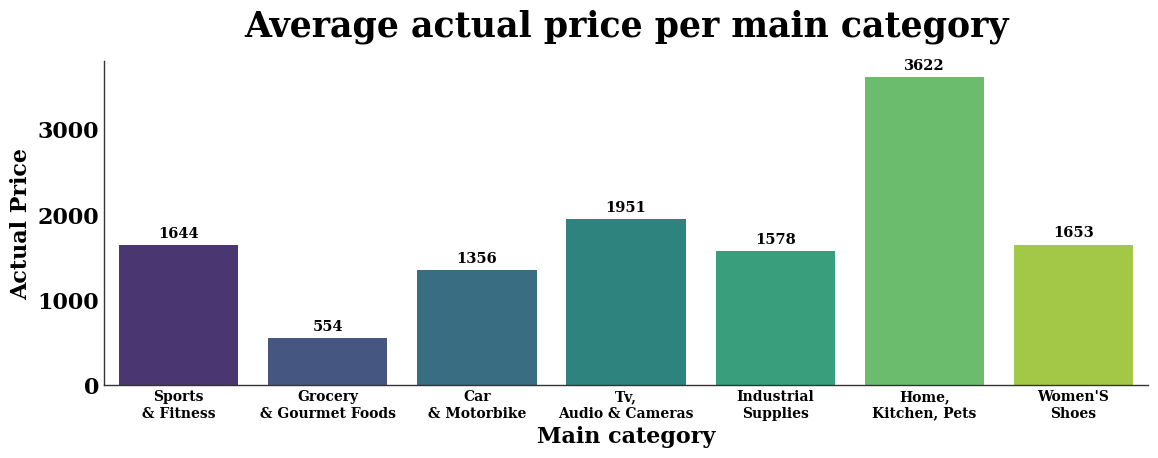

In [16]:
#### Calificación y precio real promedio por categoría principal


# top_ratings = df.groupby('main_category')[['ratings','actual_price']].mean().reset_index().sort_values(by='ratings',ascending=False)
top_ratings = df.groupby('main_category')[['ratings','actual_price']].mean().reset_index().sample(7,random_state=123)
# top_ratings = df.groupby('main_category')[['ratings']].mean().reset_index().sort_values(by='ratings',ascending=False).head(5)

labels = [i.replace(' ','\n',1).title() for i in top_ratings['main_category']]
fig, ax = plt.subplots(figsize=(12,4))

ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels)
sns.barplot(data=top_ratings,x='main_category',y='actual_price',hue='main_category',palette='viridis')

for x , y in enumerate(top_ratings['actual_price']):
    ax.text(x,y+50,f'{y:.0f}',va='bottom',ha='center')

ax.set_xlabel('Main category')
ax.set_ylabel('Actual Price')
ax.set_title('Average actual price per main category',y=1.05)
ax.spines[['top','right']].set_visible(False)

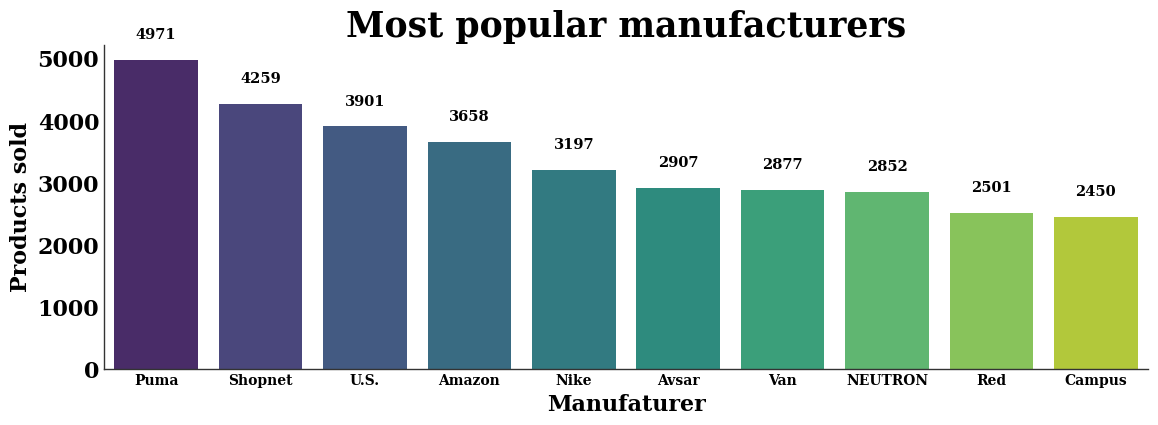

In [9]:
##Marcas más populares

top_brands = df['manufacturer'].value_counts().head(13).reset_index()


##Corregir la ambiguedad de la marca "The"

the_brands = df.loc[df['manufacturer'].isin(['The',])]
the_brands_united = pd.Series(the_brands['name'].str.split(' ',expand=True)[0] + ' ' + the_brands['name'].str.split(' ',expand=True)[1])
the_brands_united.value_counts(ascending=False)

##La manufacturadora que más vende con el nombre "The" es "The Souled" con un total de 628 apariciones. Comparado con los más de 2800 apariciones de 
##Las demás manufacturadoras en el top, esta no representa mucho. Por ende, será descartada.


##Top brands corregido, sin The,'Men's ni PC
top_brands = top_brands.loc[~top_brands['manufacturer'].isin(['The',"Men's",'PC'])]

fig, ax = plt.subplots(figsize=(12,4))

sns.barplot(data=top_brands,x='manufacturer',y='count',ax=ax,hue='manufacturer',palette='viridis')

ax.spines[['top','right']].set_visible(False)
ax.set_xlabel('Manufaturer')
ax.set_ylabel('Products sold')
ax.set_title('Most popular manufacturers')

for x,y in enumerate(top_brands['count']):
    ax.text(x , y+300,str(y),va='bottom',ha='center')

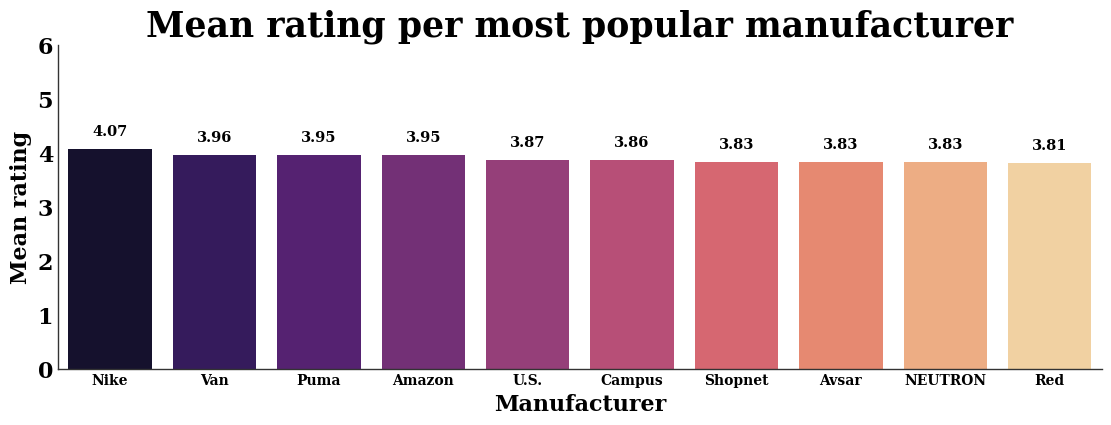

In [10]:
## Calificación promedio de los manufacturadores más populares

df_manufacturers = df.loc[df['manufacturer'].isin(top_brands['manufacturer'])]

mean_rating = df_manufacturers.groupby('manufacturer')['ratings'].mean().reset_index().sort_values(by='ratings',ascending=False)

fig, ax = plt.subplots(figsize=(12,4))

sns.barplot(data=mean_rating,x='manufacturer',y='ratings',hue='manufacturer',palette='magma')

ax.spines[['top','right']].set_visible(False)
ax.set_xlabel('Manufacturer')
ax.set_title('Mean rating per most popular manufacturer')
ax.set_ylabel('Mean rating')
ax.set_ylim(0,6)

for x, y in enumerate(mean_rating['ratings']):
    ax.text(x, y + 0.2,s=f'{y:.2f}',ha='center',va='bottom')

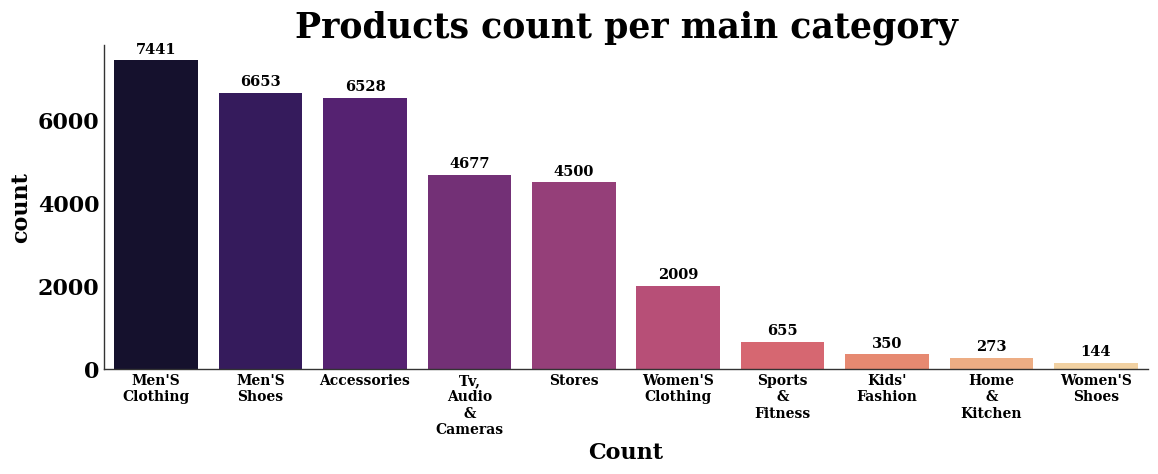

In [11]:
###Productos por categorías principales de los manufacturadores más populares

popular_main_cat = df_manufacturers['main_category'].value_counts(sort=True).head(10).reset_index()


fig, ax = plt.subplots(figsize=(12,4))

sns.barplot(data=popular_main_cat,x='main_category',y='count',hue='main_category',palette='magma')

ax.spines[['top','right']].set_visible(False)
ax.set_xlabel('Main Category')
ax.set_xlabel('Count')
ax.set_title('Products count per main category')
ax.tick_params(rotation=0,axis='x')
labels = [i.title().replace(' ','\n') for i in popular_main_cat['main_category']]

ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels)

for x, y in enumerate(popular_main_cat['count']):
    ax.text(x , y + 100, str(y),ha='center',va='bottom')
plt.show()

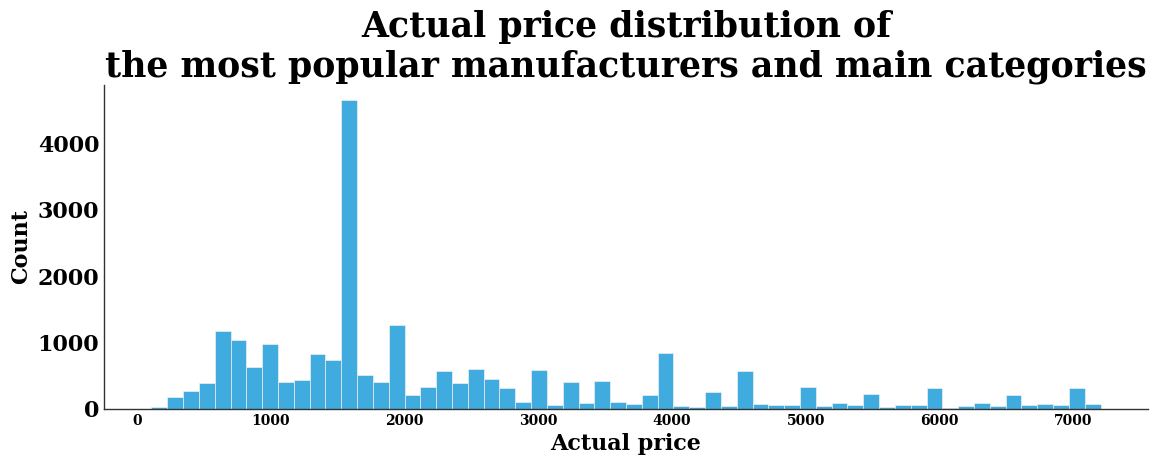

In [12]:
## Ahora, vamos a obtener un nuevo dataframe con las 10 manufacturadoras más popupulares y sus 5 categorías principales más popoulares

df_popular = df_manufacturers.loc[df_manufacturers['main_category'].isin(popular_main_cat['main_category'].iloc[:5])]

##Veamos cuáles son las sub-categorías más populares en este nuevo conjunto de datos

sub_cat = df_popular['sub_category'].value_counts(sort=True).reset_index()
sub_cat.style.background_gradient()

##Veamos el precio y rating promedio por categoría

df_popular.groupby('main_category')[['actual_price','ratings']].mean().style.background_gradient()

##Distribución del precio real

fig, ax = plt.subplots(figsize=(12,4))

sns.histplot(data=df_popular,x='actual_price')

ax.spines[['top','right']].set_visible(False)
ax.set_xlabel('Actual price')
ax.set_title('Actual price distribution of\nthe most popular manufacturers and main categories')
plt.show()

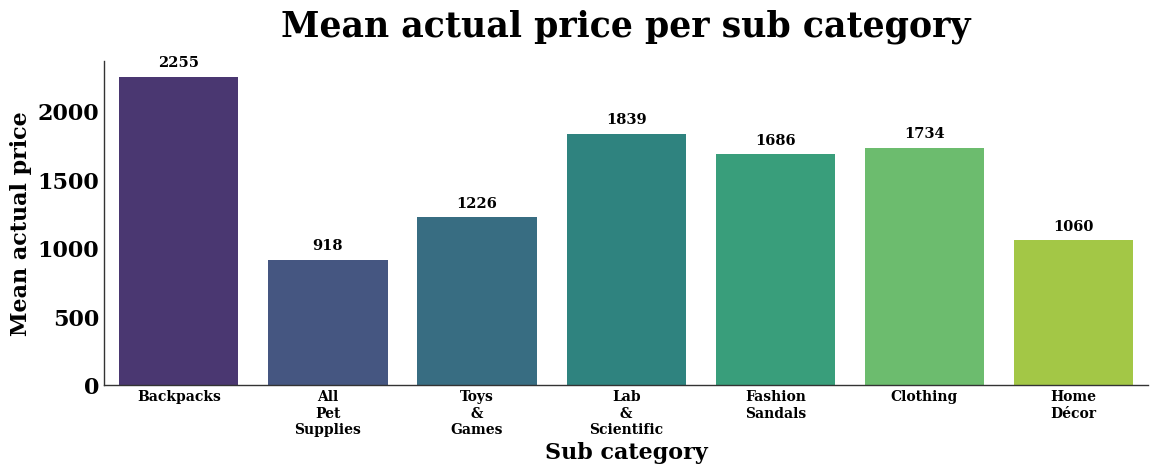

In [45]:
##Average actual price per sub category

sub_cat = df.groupby('sub_category')['actual_price'].mean().reset_index().sample(7)

fig, ax = plt.subplots(figsize=(12,4))

sns.barplot(data=sub_cat,x='sub_category',y='actual_price',hue='sub_category',palette='viridis')

labels = [i.title().replace(' ','\n') for i in sub_cat['sub_category']]
ax.set_xlabel('Sub category')
ax.set_ylabel('Mean actual price')
ax.set_title('Mean actual price per sub category',y=1.05)

ax.spines[['top','right']].set_visible(False)

ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels)


for x, y in enumerate(sub_cat['actual_price']):
    ax.text(x,y+50,f'{y:.0f}',ha='center',va='bottom')
plt.show()

<Axes: >

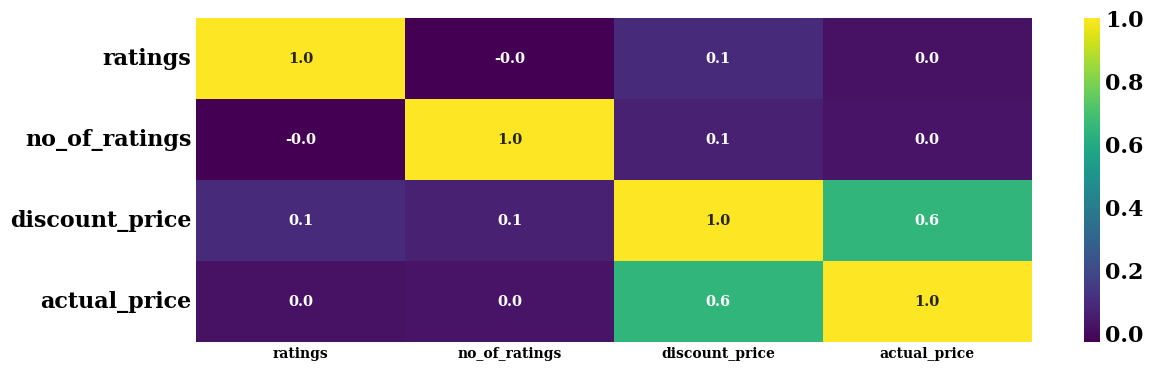

In [54]:
##Correlaciones 

correlaciones = df.select_dtypes('number').corr()

fig, ax = plt.subplots(figsize=(12,4))
sns.heatmap(correlaciones,annot=True,ax=ax,cmap='viridis',fmt='.1f')

<Axes: xlabel='ratings'>

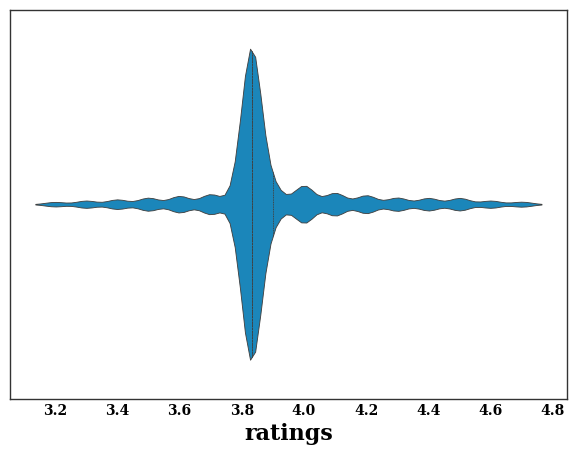

In [336]:
##Distribución del ratings de las marcas más populares

sns.violinplot(data=df_popular,x='ratings',inner='quart')

In [273]:
cm = sns.light_palette("green", as_cmap=True)

# popular_main_cat.style.background_gradient(cmap='viridis')
df_manufacturers.iloc[20:25,5:].style.background_gradient(axis=1)

,ratings,no_of_ratings,discount_price,actual_price,manufacturer,discount %
2128,4.000000,nan,419.000000,850.000000,Amazon,51.000000
2242,4.000000,nan,219.000000,400.000000,Amazon,45.000000
2417,4.000000,nan,1699.000000,3000.000000,Amazon,43.000000
2535,4.100000,nan,1899.000000,3300.000000,Amazon,42.000000
2565,nan,109.000000,400.000000,499.000000,Amazon,20.000000
